### Vehicle Detection

Jay Urain

The goal of this project is to write a software pipeline to detect vehicles in a video.


#### The Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier. 
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.  
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

Some example images for testing your pipeline on single frames are located in the `test_images` folder.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include them in your writeup for the project by describing what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

**As an optional challenge** Once you have a working pipeline for vehicle detection, add in your lane-finding algorithm from the last project to do simultaneous lane-finding and vehicle detection!

**If you're feeling ambitious** (also totally optional though), don't stop there!  We encourage you to go out and take video of your own, and show us how you would implement this project on a new video!



Credits: Much of the code is based on samples from the Udacity Self-Driving Car class.

#### Import statements

In [58]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

#### Load data

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32
car_image.shape (64, 64, 3)


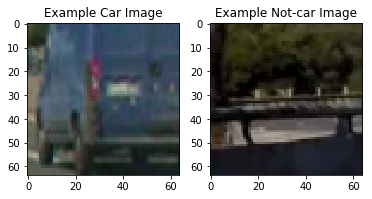

In [59]:
# images are divided up into vehicles and non-vehicles

car_images = glob.glob('data/vehicles/**/*.png', recursive=True)
non_car_images = glob.glob('data/non-vehicles/**/*.png', recursive=True)
cars = []
notcars = []

for image in car_images:
    cars.append(image)

for image in non_car_images:
    notcars.append(image)
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
print('car_image.shape', car_image.shape)
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

#### Visualize data

Randomly sample and display *car* and *not car* images.

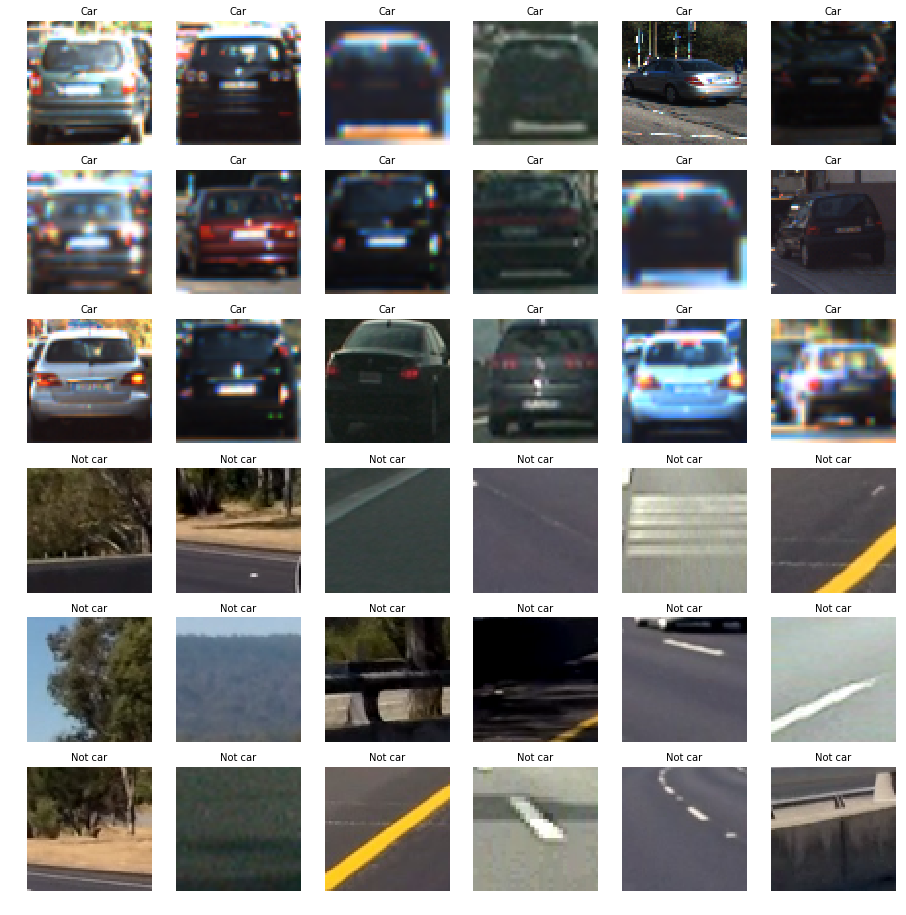

In [103]:
fig, axs = plt.subplots(6,6, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(18):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Car', fontsize=10)
    axs[i].imshow(img)
    
for i in np.arange(18,36):
    img = cv2.imread(non_car_images[np.random.randint(0,len(non_car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('Not car', fontsize=10)
    axs[i].imshow(img)

### Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier


#### HOG - Histogram of Gradients

The HOG visualization is a representation that shows the dominant gradient direction within each cell with brightness corresponding to the strength of gradients in that cell.

If you set pixels_per_cell=(8, 8), cells_per_block=(2, 2), and orientations=9, the output is an array of shape 7×7×2×2×9. This corresponds to the fact that a grid of 7×7 blocks were sampled, with 2×2 cells in each block and 9 orientations per cell. You can unroll this array into a feature vector using features.ravel(), which yields in this case a one dimensional array of length 1764.

Alternatively, you can set the feature_vector=True flag when calling the hog() function to automatically unroll the features. 

http://scikit-image.org/  

http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature%20hog#skimage.feature.hog 

http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

The function below takes an image with specifications for orientations, pixels_per_cell, and cells_per_block, as well as flags set for whether or not you want the feature vector unrolled and/or a visualization image. The pixels per cell are normalized over the cells per block.


In [61]:
from skimage.feature import hog
        
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=False,
                          visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=False,
                          visualise=vis, feature_vector=feature_vec)
        return features


#### Visualize HOG

Image index: 4457


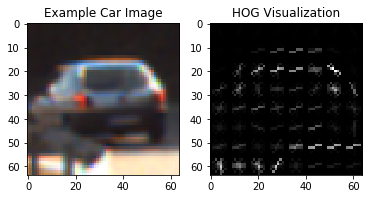

In [62]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
ind = 4457
print("Image index:", ind)
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

#### Define function to extract and combine features from an array of car and non-car features

In [63]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

### Create and evaluate an SVM classifier with default HOG parameters and an RGB color space

In [64]:
# Reduce the sample size because HOG features are slow to compute
# sample_size = 1000
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


52.52 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764


#### Train Linear SVM

In [65]:
def trainSVM(X_train, y_train, n_predict=10):
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc

svc = trainSVM(X_train, y_train)

3.93 Seconds to train SVC...
Test Accuracy of SVC =  0.9552
My SVC predicts:  [ 0.  1.  0.  1.  0.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  0.  1.  0.  0.  0.  1.  0.  1.]
0.00171 Seconds to predict 10 labels with SVC


#### Perform feature ablation study

In [53]:
# reload data
car_images = glob.glob('data/vehicles/**/*.png', recursive=True)
non_car_images = glob.glob('data/non-vehicles/**/*.png', recursive=True)
cars = []
notcars = []

for image in car_images:
    cars.append(image)

for image in non_car_images:
    notcars.append(image)

In [101]:
### TODO: Tweak these parameters and see how the results change.
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

# Evaluate colorspaces
# colorspaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb'] # trouble with LUV colorspace Nan
colorspaces = ['RGB', 'HSV', 'HLS', 'YUV', 'YCrCb']
hog_channels = [0, 1, 2,'ALL']
orientations = [6, 9, 12]
# pixels_per_cell = [4, 8, 16]
# cell_per_block = [2, 4, 8]

for colorspace in colorspaces:
    for hog_channel in hog_channels:
        for orient in orientations:
            t=time.time()
            print('***')
            print('Colorspace', colorspace, 'HOG Channel', hog_channel)
            car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel)
            notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel)
            t2 = time.time()
            print(round(t2-t, 2), 'Seconds to extract HOG features...')
            # Create an array stack of feature vectors
            X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
            # Fit a per-column scaler
#             X_scaler = StandardScaler().fit(X)
            # Apply the scaler to X
#             scaled_X = X_scaler.transform(X)

            # Define the labels vector
            y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

            # Split up data into randomized training and test sets
            rand_state = np.random.randint(0, 100)
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=rand_state)

            print('Using:',orient,'orientations',pix_per_cell,
                'pixels per cell and', cell_per_block,'cells per block')
            print('Feature vector length:', len(X_train[0]))
            # Use a linear SVC 
            svc = trainSVM(X_train, y_train)

***
Colorspace RGB HOG Channel 0
53.12 Seconds to extract HOG features...
Using: 6 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1176
3.23 Seconds to train SVC...
Test Accuracy of SVC =  0.9521
My SVC predicts:  [ 1.  1.  1.  1.  1.  0.  1.  1.  0.  0.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  0.  1.  1.  0.  1.]
0.00201 Seconds to predict 10 labels with SVC
***
Colorspace RGB HOG Channel 0
45.42 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
4.23 Seconds to train SVC...
Test Accuracy of SVC =  0.9611
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  0.  0.  0.  1.  1.]
0.00141 Seconds to predict 10 labels with SVC
***
Colorspace RGB HOG Channel 0
43.92 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2352
4.14 Seconds to train SVC...
Test Accuracy of S

96.49 Seconds to extract HOG features...
Using: 6 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 3528
4.33 Seconds to train SVC...
Test Accuracy of SVC =  0.9814
My SVC predicts:  [ 0.  0.  0.  1.  0.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  1.  1.  1.  0.  0.]
0.00158 Seconds to predict 10 labels with SVC
***
Colorspace HSV HOG Channel ALL
99.35 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
6.72 Seconds to train SVC...
Test Accuracy of SVC =  0.9783
My SVC predicts:  [ 0.  0.  1.  0.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  1.  1.  0.  0.  0.]
0.00153 Seconds to predict 10 labels with SVC
***
Colorspace HSV HOG Channel ALL
118.69 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7056
5.34 Seconds to train SVC...
Test Accuracy of SVC =  0.9845
My SVC predicts

45.16 Seconds to extract HOG features...
Using: 6 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1176
3.31 Seconds to train SVC...
Test Accuracy of SVC =  0.9291
My SVC predicts:  [ 1.  1.  1.  0.  1.  1.  0.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  1.  1.  0.  1.  0.]
0.0019 Seconds to predict 10 labels with SVC
***
Colorspace YUV HOG Channel 2
44.84 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
4.18 Seconds to train SVC...
Test Accuracy of SVC =  0.9203
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
0.00154 Seconds to predict 10 labels with SVC
***
Colorspace YUV HOG Channel 2
43.3 Seconds to extract HOG features...
Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2352
4.1 Seconds to train SVC...
Test Accuracy of SVC =  0.9268
My SVC predicts:  [ 0. 

### Method for Using Classifier to Detect Cars in an Image¶


#### Create a dataset using empirically determined optimal parameters


In [66]:
import pickle
# reload full dataset

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


100.51 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292


#### Train Linear SVM classifier


In [69]:
# Use a linear SVC 
svc = trainSVM(X_train, y_train, n_predict=1000)

5.79 Seconds to train SVC...
Test Accuracy of SVC =  0.9837
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  1.  1.  1.  0.  0.  1.  0.  1.  1.  1.  1.  1.
  0.  0.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  0.  0.  1.  0.  0.  1.
  1.  0.  1.  0.  1.  1.  0.  0.  0.  1.  0.  1.  1.  0.  1.  1.  1.  0.
  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.  1.  1.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  1.  0.  0.  0.  1.  1.  0.
  0.  0.  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.  0.  0.  1.  1.  0.
  1.  1.  1.  0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  1.  0.  1.  1.  1.
  1.  1.  0.  1.  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.  1.  1.  0.
  1.  1.  0.  0.  0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  0.  0.  1.  0.  1.  0.  1.  0.
  1.  0.  1.  1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  1.  0.  1.  1.
  0.  1.  0.  1.  1.  0.  1.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  1.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  

### find_cars method to detect cars in images

In [70]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):

    rectangles = []
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image) 
        
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

#             # Extract the image patch
#             subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
#             # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)

#             # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
#             #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#             test_prediction = svc.predict(test_features)
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return rectangles
    


#### Test find_cars on sample image

In [71]:
ystart = 400
ystop = 656
scale = 1.5
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
 
test_img = mpimg.imread('test_images/test1.jpg')

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

# plt.imshow(out_img)
print(len(rectangles), 'rectangles found in image')

11 rectangles found in image


#### Method for Using Classifier to Detect Cars in an Image¶

In [72]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#### Draw rectangle on sample image

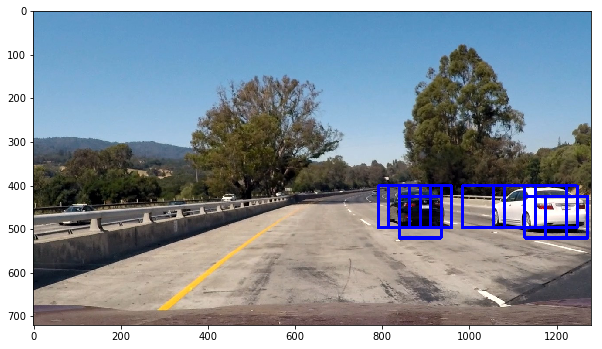

In [73]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

#### Show All Potential Search Areas  

Becuase the size and position of cars in the image will be different depending on their distance from the camera, find_cars will have to be called a few times with different ystart, ystop, and scale values. These next few blocks of code are for determining the values for these parameters that work best.

Number of boxes:  154


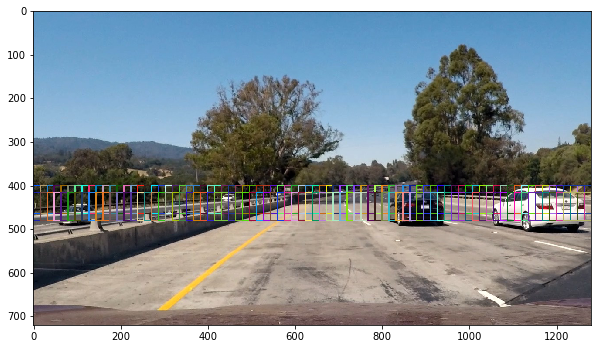

In [74]:
test_img = mpimg.imread('./test_images/test1.jpg')

rects = []

ystart = 400
ystop = 464
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 416
ystop = 480
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

### Combine Various Sliding Window Searches¶


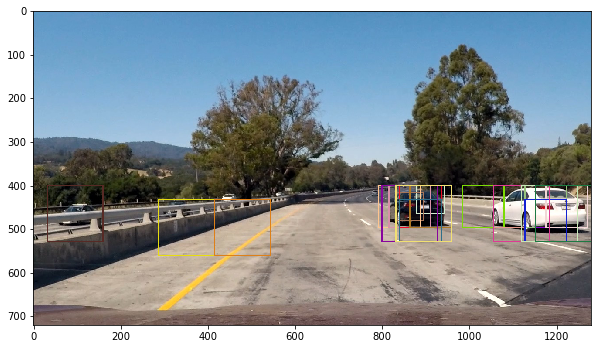

In [78]:
test_img = mpimg.imread('./test_images/test1.jpg')

rectangles = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 596
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 464
ystop = 660
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

*Note: scale < 1.5 generates false positives*

### Heatmap

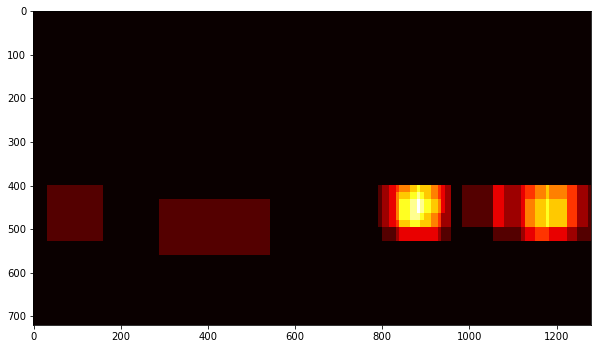

In [87]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

#### Heatmap threshold

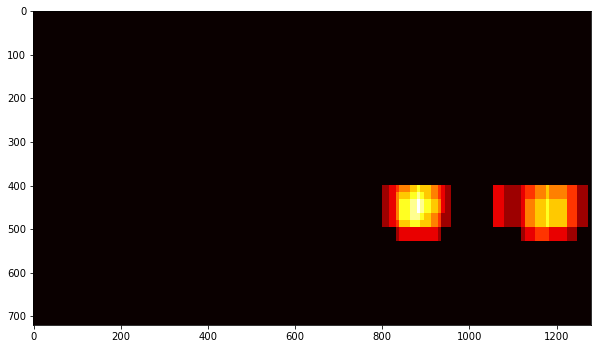

In [88]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

*Not: heatmap threshold removed light shadows on left*

#### Add oject labels to heap map

2 cars found


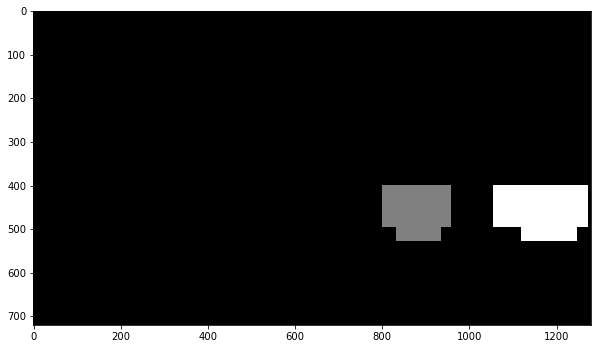

In [89]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

#### Draw bounding boxes around found objects

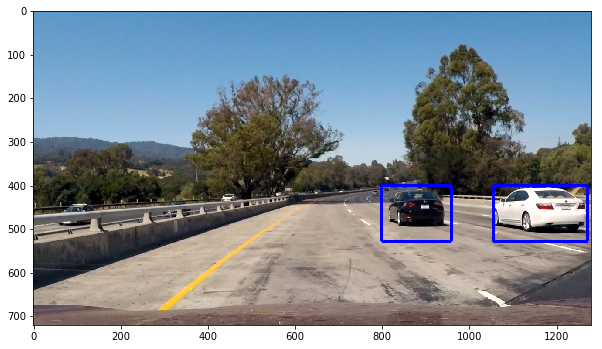

In [90]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

### Integrate processing 

In [93]:
def process_image(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

#### Run pipeline for test images


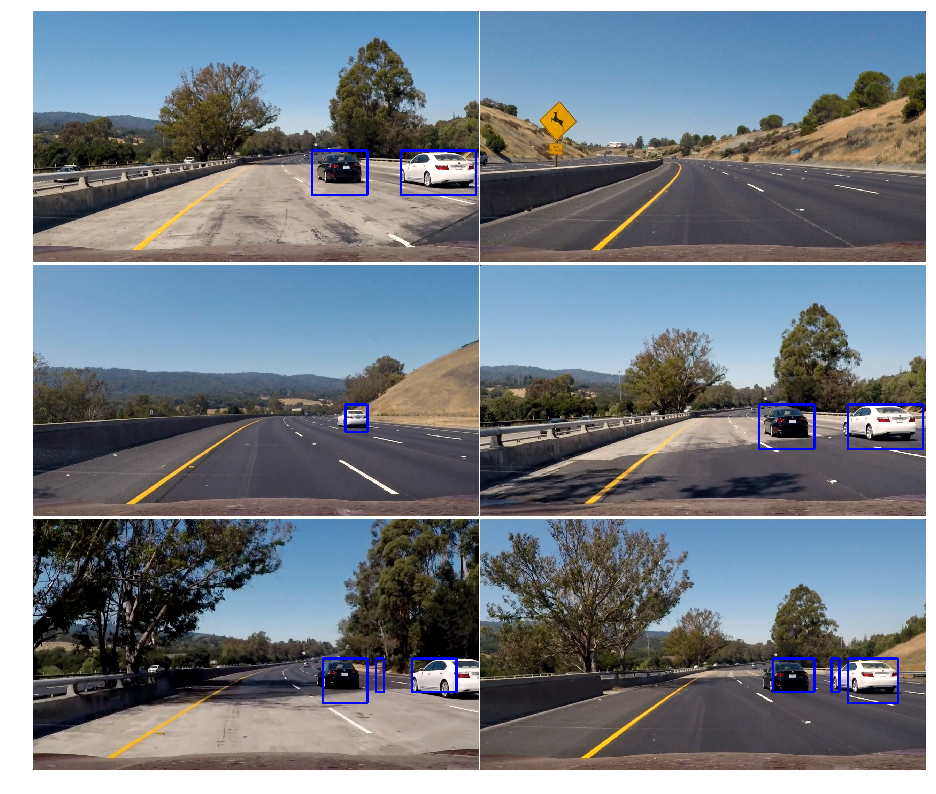

In [95]:
test_images = glob.glob('test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_image(mpimg.imread(im)))
    axs[i].axis('off')

### Video pipeline

#### Test video

In [97]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:22<00:00,  1.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 21.4 s, sys: 1.53 s, total: 23 s
Wall time: 23.1 s


In [98]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

#### Project video

In [99]:
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [12:22<00:00,  1.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 11min 53s, sys: 49.9 s, total: 12min 43s
Wall time: 12min 23s


In [100]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

#### Tips and tricks of the project

Extract HOG features just once for the entire region of interest in each full image / video frame
In one of the previous exercises you extracted HOG features from each individual window as you searched across the image, but it turns out this is rather inefficient. To speed things up, extract HOG features just once for the entire region of interest (i.e. lower half of each frame of video) and subsample that array for each sliding window. To do this, apply skimage.feature.hog() with the flag feature_vec=False, like this:




The output feature_array will have a shape of (n_yblocks, n_xblocks, 2, 2, 9), where n_yblocks and n_xblocks are determined by the shape of your region of interest (i.e. how many blocks fit across and down your image in x and y).

So, for example, if you used cells_per_block=2 in extracting features from the 64x64 pixel training images, then you would want to extract subarrays of shape (7, 7, 2, 2, 9) from feature_array and then use np.ravel() to unroll the feature vector.

#### Make sure your images are scaled correctly 

The training dataset provided for this project ( vehicle and non-vehicle images) are in the .png format. Somewhat confusingly, matplotlib image will read these in on a scale of 0 to 1, but cv2.imread() will scale them from 0 to 255. Be sure if you are switching between cv2.imread() and matplotlib image for reading images that you scale them appropriately! Otherwise your feature vectors can get screwed up.

To add to the confusion, matplotlib image will read .jpg images in on a scale of 0 to 255 so if you are testing your pipeline on .jpg images remember to scale them accordingly. And if you take an image that is scaled from 0 to 1 and change color spaces using cv2.cvtColor() you'll get back an image scaled from 0 to 255. So just be sure to be consistent between your training data features and inference features!

#### Be sure to normalize your training data  

Use sklearn.preprocessing.StandardScaler() to normalize your feature vectors for training your classifier as described in this lesson. Then apply the same scaling to each of the feature vectors you extract from windows in your test images.

#### Random shuffling of data

When dealing with image data that was extracted from video, you may be dealing with sequences of images where your target object (vehicles in this case) appear almost identical in a whole series of images. In such a case, even a randomized train-test split will be subject to overfitting because images in the training set may be nearly identical to images in the test set.

For the project vehicles dataset, the GTI* folders contain time-series data. In the KITTI folder, you may see the same vehicle appear more than once, but typically under significantly different lighting/angle from other instances.

While it is possible to achieve a sufficiently good result on the project without worrying about time-series issues, if you really want to optimize your classifier, you should devise a train/test split that avoids having nearly identical images in both your training and test sets. This means extracting the time-series tracks from the GTI data and separating the images manually to make sure train and test images are sufficiently different from one another.

#### Project Details

For this project, we provide you with a labeled dataset and your job is to decide what features to extract, then train a classifier and ultimately track vehicles in a video stream. Here are links to the labeled data for vehicle and non-vehicle examples to train your classifier. These example images come from a combination of the GTI vehicle image database, the KITTI vision benchmark suite, and examples extracted from the project video itself.

Udacity recently released a labeled dataset of our own, which you are encouraged to take advantage of to augment your training data. You can find the Udacity data here. In each of the folders containing images there's a csv file containing all the labels and bounding boxes. To add vehicle images to your training data, you'll need to use the csv files to extract the bounding box regions and scale them to the same size as the rest of the training images.

The project video will be the same one as for the Advanced Lane Finding Project. The reason for this is that, assuming you already have a working implementation of lane finding for this video, once your vehicle detection pipeline works, you can add it to your lane finding pipeline and do both analyses simultaneously! You can use the test images from the lane finding project to start with, or extract other frames from the video to work on.

